# 0. Install and Import Dependencies

In [1]:
!pip list

Package                           Version
--------------------------------- ------------------
absl-py                           2.1.0
aiobotocore                       2.12.3
aiohappyeyeballs                  2.4.0
aiohttp                           3.10.5
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.16
altair                            5.0.1
anaconda-anon-usage               0.4.4
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.5.1
anaconda-navigator                2.6.3
anaconda-project                  0.11.1
annotated-types                   0.6.0
anyio                             4.2.0
appdirs                           1.4.4
archspec                          0.2.3
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
arrow                             1.2.3
astroid                           2.14.2
astropy          

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [4]:
!pip install librosa

In [3]:
import os
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import tensorflow as tf
import numpy as np
#import wandb
import imageio #2.23.0
from typing import List, Optional, Sequence, Tuple, Union
from matplotlib import pyplot as plt
from PIL import Image
#from wandb.integration.keras import WandbMetricsLogger


In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# Build Data Loading Functions

In [7]:
import gdown

In [8]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=5a7ab4dd-faaa-46ec-a68d-eb7e4b4c6044
To: c:\Users\omkar\LipNet\data.zip
100%|██████████| 423M/423M [02:03<00:00, 3.44MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [9]:
audio_files_path = "C:/Users/omkar/Lip Read/Deepfake_Audio_Classifier/KAGGLE/AUDIO"

folders = os.listdir(audio_files_path)
print(folders)

['FAKE', 'REAL']


In [13]:
real_audio = "C:/Users/omkar/LipNet/Deepfake_Audio_Classifier/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3"
fake_audio = "C:/Users/omkar/LipNet/Deepfake_Audio_Classifier/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3"

In [14]:
data = []
labels = []

for folder in folders:
    files = os.listdir(os.path.join(audio_files_path, folder))
    for file in tqdm(files):
        file_path = os.path.join(audio_files_path, folder, file)
        audio, sample_rate = librosa.load(file_path, res_type="kaiser_fast")
        mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_features_scaled = np.mean(mfccs_features.T, axis=0)
        data.append(mfccs_features_scaled)
        labels.append(folder)

  0%|          | 0/56 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:40<00:00,  5.00s/it]


In [15]:
feature_df = pd.DataFrame({"features": data, "class": labels})
feature_df.head()

,features,class
0,"[-260.1085, 100.856926, -25.453163, -0.2690358...",FAKE
1,"[-258.9036, 93.914345, -27.627077, -1.9326235,...",FAKE
2,"[-268.50894, 118.533066, -38.89298, 13.812951,...",FAKE
3,"[-272.68378, 101.50515, -22.251564, 4.101077, ...",FAKE
4,"[-254.73932, 66.81036, -33.19487, -4.094302, -...",FAKE


In [16]:
feature_df["class"].value_counts()

FAKE    56
REAL     8
Name: class, dtype: int64

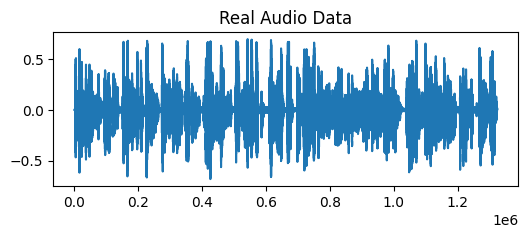

In [17]:
real_ad, real_sr = librosa.load(real_audio)
plt.figure(figsize=(6, 2))
plt.plot(real_ad)
plt.title("Real Audio Data")
plt.show()

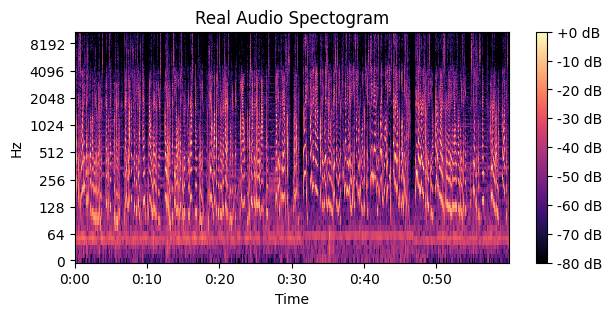

In [18]:
real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref=np.max)

plt.figure(figsize=(7, 3))
librosa.display.specshow(real_spec, sr=real_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Real Audio Spectogram")
plt.show()

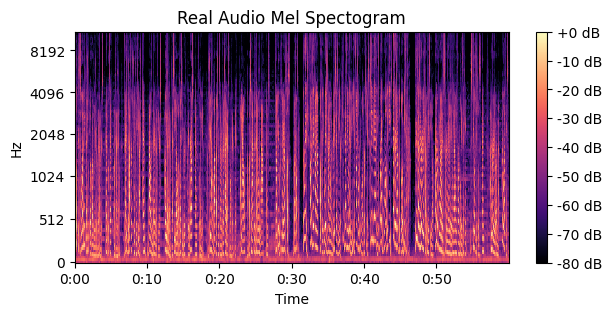

In [19]:
real_mel_spect = librosa.feature.melspectrogram(y=real_ad, sr=real_sr)
real_mel_spect = librosa.power_to_db(real_mel_spect, ref=np.max)

plt.figure(figsize=(7, 3))
librosa.display.specshow(real_mel_spect, y_axis="mel", x_axis="time")
plt.title("Real Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

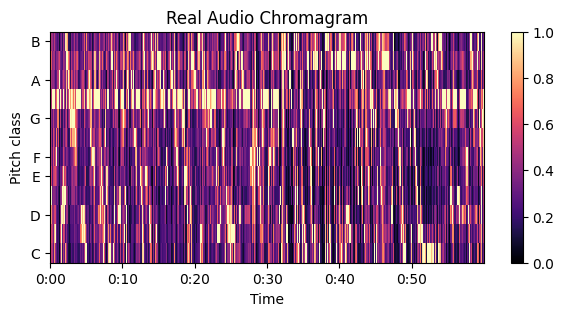

In [20]:
real_chroma = librosa.feature.chroma_cqt(y=real_ad, sr=real_sr, bins_per_octave=36)

plt.figure(figsize=(7, 3))
librosa.display.specshow(real_chroma, sr=real_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Real Audio Chromagram")
plt.show()

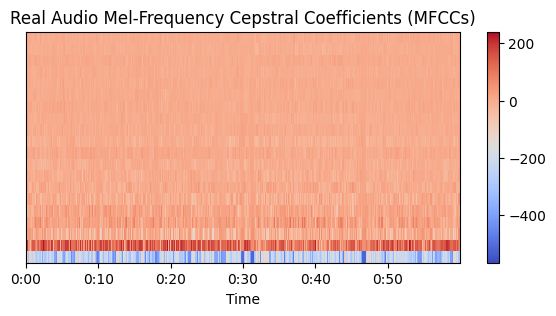

In [21]:
real_mfccs = librosa.feature.mfcc(y=real_ad, sr=real_sr)

plt.figure(figsize=(7, 3))
librosa.display.specshow(real_mfccs, sr=real_sr, x_axis="time")
plt.colorbar()
plt.title("Real Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()

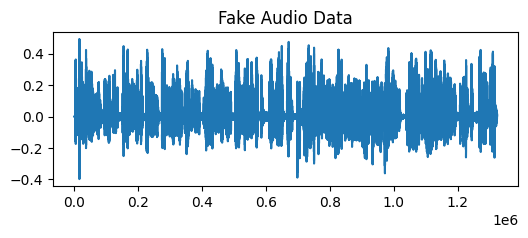

In [22]:
fake_ad, fake_sr = librosa.load(fake_audio)
plt.figure(figsize=(6, 2))
plt.plot(fake_ad)
plt.title("Fake Audio Data")
plt.show()

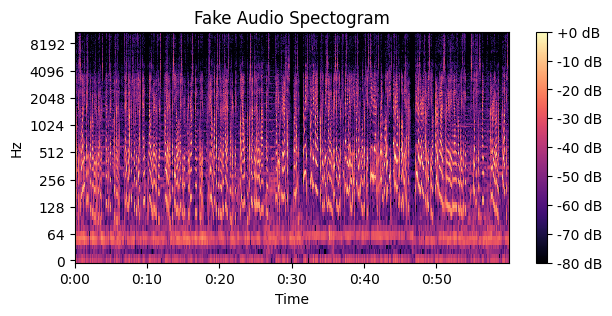

In [23]:
fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref=np.max)

plt.figure(figsize=(7, 3))
librosa.display.specshow(fake_spec, sr=fake_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Fake Audio Spectogram")
plt.show()

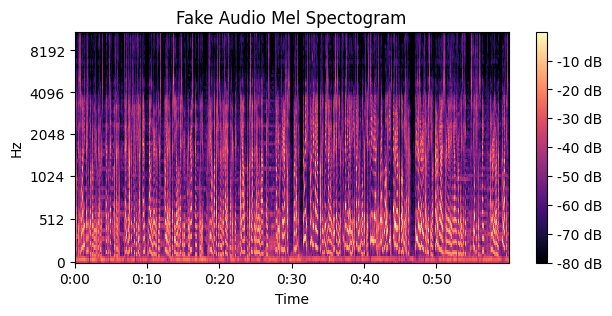

In [24]:
fake_mel_spect = librosa.feature.melspectrogram(y=fake_ad, sr=fake_sr)
fake_mel_spect = librosa.power_to_db(fake_mel_spect, ref=np.max)

plt.figure(figsize=(7, 3))
librosa.display.specshow(fake_mel_spect, y_axis="mel", x_axis="time")
plt.title("Fake Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

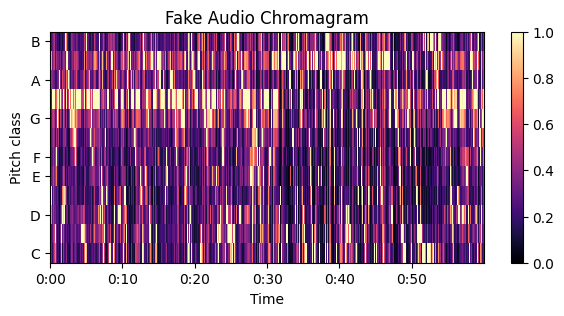

In [25]:
fake_chroma = librosa.feature.chroma_cqt(y=fake_ad, sr=fake_sr, bins_per_octave=36)

plt.figure(figsize=(7, 3))
librosa.display.specshow(fake_chroma, sr=fake_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Fake Audio Chromagram")
plt.show()

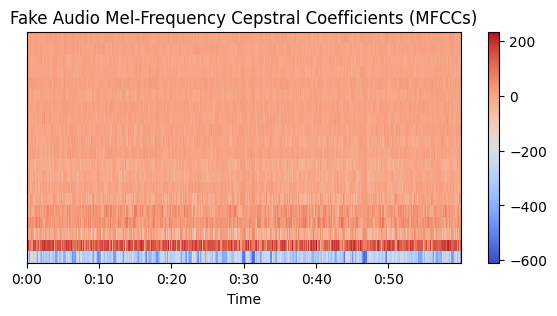

In [26]:
fake_mfccs = librosa.feature.mfcc(y=fake_ad, sr=fake_sr)

plt.figure(figsize=(7, 3))
librosa.display.specshow(fake_mfccs, sr=fake_sr, x_axis="time")
plt.colorbar()
plt.title("Fake Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()

In [27]:
def label_encoder(column):
    le = LabelEncoder().fit(column)
    print(column.name, le.classes_)
    return le.transform(column)

In [28]:
feature_df["class"] = label_encoder(feature_df["class"])

class ['FAKE' 'REAL']


In [36]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [37]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [38]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")

# Function to convert char to num
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

In [39]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [40]:
char_to_num(['o','m','k','a','r'])

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([15, 13, 11,  1, 18], dtype=int64)>

In [41]:
num_to_char([15,  13,  11, 1, 18])

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'o', b'm', b'k', b'a', b'r'], dtype=object)>

In [42]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [43]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [44]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [45]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [46]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

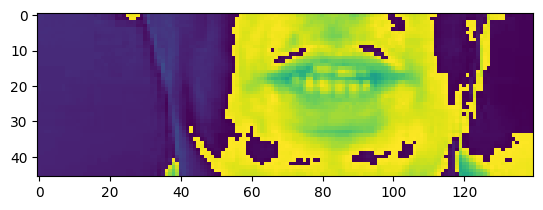

In [47]:
plt.imshow(frames[40])

In [48]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [49]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [ ]:
def mappable_function(path: str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

1. Lip Reading

In [51]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500)
# Maps the data to our data loader
data = data.map(mappable_function)
# Get batch size of 2, pad 75 frames and 40 tokens
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)

# Split the dataset
lip_train = data.take(450)
lip_test = data.skip(450)

In [52]:
len(lip_test)

50

In [53]:
frames, alignments = data.as_numpy_iterator().next()
len(frames)

2

In [54]:
frames.shape

(2, 75, 46, 140, 1)

In [55]:
alignments.shape

(2, 40)

In [56]:
iter_ = data.as_numpy_iterator()

val = next(iter_)

val[0][0].shape

(75, 46, 140, 1)

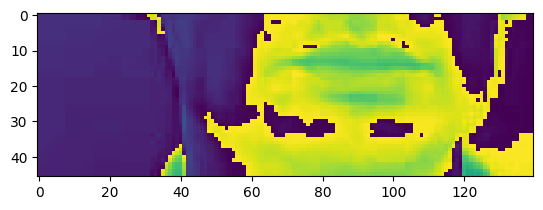

In [57]:
plt.imshow(val[0][0][0])

In [58]:
import imageio


# Convert the frame to uint8 and ensure it has 3 channels (RGB)
frame_to_save = val[0][0][0]  # Select the first frame from val[0][0]
frame_to_save = frame_to_save.astype(np.uint8) # Convert to unit8
# Stack grayscale image to create 3 channels
frame_to_save = np.stack((frame_to_save,)*3, axis=-1)

# Save the GIF
imageio.mimsave('C:/Users/omkar/LipNet/animation.gif', frame_to_save, fps=10)
#imageio.mimsave('./animation.gif', val[0][0], fps=10)

In [59]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place green with e six now'>

In [60]:
val[0][0].shape

(75, 46, 140, 1)

2. Deep Fake Audio

In [61]:
audio_X = np.array(feature_df["features"].tolist())
audio_y = np.array(feature_df["class"].tolist())

In [62]:
ros = RandomOverSampler(random_state=42)
audio_X_resampled, audio_y_resampled = ros.fit_resample(audio_X, audio_y)

In [63]:
audio_y_resampled = to_categorical(audio_y_resampled)

In [64]:
audio_X_train, audio_X_test, audio_y_train, audio_y_test = train_test_split(audio_X_resampled, audio_y_resampled, test_size=0.2, random_state=42)

In [65]:
num_labels = len(feature_df["class"].unique())
num_labels

2

In [66]:
input_shape = feature_df["features"][0].shape
input_shape

(40,)

# 3. Design the Deep Neural Network

1. Lip Reading

In [67]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [49]:
#data.as_numpy_iterator().next()[0][0].shape

In [68]:
lip_model = Sequential()
lip_model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
lip_model.add(Activation('relu'))
lip_model.add(MaxPool3D((1,2,2)))

lip_model.add(Conv3D(256, 3, padding='same'))
lip_model.add(Activation('relu'))
lip_model.add(MaxPool3D((1,2,2)))

lip_model.add(Conv3D(75, 3, padding='same'))
lip_model.add(Activation('relu'))
lip_model.add(MaxPool3D((1,2,2)))

# Separate each time unit from the 75 units to be fed into our LSTM
lip_model.add(TimeDistributed(Flatten()))

# Note: The paper uses GRU but we used an LSTM here; in the future, I want to use a transformer
lip_model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
lip_model.add(Dropout(.5))

lip_model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
lip_model.add(Dropout(.5))

lip_model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [69]:
lip_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [70]:
# Test the model
lip_yhat = lip_model.predict(val[0])

1/1 [==============================] - 4s 4s/step


In [71]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(lip_yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'clllllllllllllllllllqqqllllllllqqqqqqqqqqqqllllllllllllllllllllllllllllllqq'>

In [72]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in lip_yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'clllllllllllllllllllqqqllllllllqqqqqqqqqqqqllllllllllllllllllllllllllllllqq'>

2. Deep Fake Audio

In [73]:
audio_model = Sequential()
audio_model.add(Dense(128, input_shape=input_shape))
audio_model.add(Activation(activation="relu"))
audio_model.add(Dropout(0.5))
audio_model.add(Dense(256))
audio_model.add(Activation(activation="relu"))
audio_model.add(Dropout(0.5))
audio_model.add(Dense(128))
audio_model.add(Activation(activation="relu"))
audio_model.add(Dropout(0.5))
audio_model.add(Dense(num_labels))
audio_model.add(Activation(activation="softmax"))

audio_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

audio_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               5248      
                                                                 
 activation_3 (Activation)   (None, 128)               0         
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 activation_4 (Activation)   (None, 256)               0         
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [ ]:
#early = EarlyStopping(monitor="val_loss", patience=10)

audio_history = audio_model.fit(audio_X_train, audio_y_train, validation_data=(audio_X_test, audio_y_test), batch_size=32, epochs=300 )#, callbacks=[early])


Epoch 1/300
3/3 [==============================] - 1s 120ms/step - loss: 23.5924 - accuracy: 0.4607 - val_loss: 1.7616 - val_accuracy: 0.6522
Epoch 2/300
3/3 [==============================] - 0s 21ms/step - loss: 23.3270 - accuracy: 0.4607 - val_loss: 9.8120 - val_accuracy: 0.3478
Epoch 3/300
3/3 [==============================] - 0s 21ms/step - loss: 17.0015 - accuracy: 0.4831 - val_loss: 8.6923 - val_accuracy: 0.3478
Epoch 4/300
3/3 [==============================] - 0s 22ms/step - loss: 21.5680 - accuracy: 0.4831 - val_loss: 5.7619 - val_accuracy: 0.3478
Epoch 5/300
3/3 [==============================] - 0s 21ms/step - loss: 14.5880 - accuracy: 0.5281 - val_loss: 2.2949 - val_accuracy: 0.3478
Epoch 6/300
3/3 [==============================] - 0s 21ms/step - loss: 10.5327 - accuracy: 0.5618 - val_loss: 0.3705 - val_accuracy: 0.8261
Epoch 7/300
3/3 [==============================] - 0s 25ms/step - loss: 15.8388 - accuracy: 0.4831 - val_loss: 0.4828 - val_accuracy: 0.7391
Epoch 8/300


# 5. Make a Prediction

1. Lip Reading

In [75]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=71e401e8-1009-473d-ba0a-f329e0a7df3e
To: c:\Users\omkar\LipNet\checkpoints.zip
100%|██████████| 94.5M/94.5M [00:28<00:00, 3.27MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [77]:
lip_model.load_weights('models/checkpoint')

In [80]:
test_data = lip_test.as_numpy_iterator()

In [81]:
sample = test_data.next()

In [83]:
lip_yhat = lip_model.predict(sample[0])

1/1 [==============================] - 2s 2s/step


In [84]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l seven soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green with e nine again'>]

In [86]:
decoded = tf.keras.backend.ctc_decode(lip_yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [87]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l seven soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green with nine again'>]

2. Deep Fake Audio

In [88]:
audio_test_loss, audio_test_acc = audio_model.evaluate(audio_X_test, audio_y_test)
print("Audio Test Loss:", audio_test_loss)
print("Audio Test Accuracy:", audio_test_acc)

1/1 [==============================] - 0s 22ms/step - loss: 0.6260 - accuracy: 0.7391
Audio Test Loss: 0.6259628534317017
Audio Test Accuracy: 0.739130437374115


# Test on a Video

1. Lip Reading

In [89]:
lip_sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [90]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [lip_sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [91]:
lip_yhat = lip_model.predict(tf.expand_dims(lip_sample[0], axis=0))

1/1 [==============================] - 1s 1s/step


In [92]:
decoded = tf.keras.backend.ctc_decode(lip_yhat, input_length=[75], greedy=True)[0][0].numpy()

In [93]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

2. Deep Fake Audio

In [94]:
def detect_fake(filename):
    sound_signal, sample_rate = librosa.load(filename, res_type="kaiser_fast")
    mfcc_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
    mfccs_features_scaled = np.mean(mfcc_features.T, axis=0)
    mfccs_features_scaled = mfccs_features_scaled.reshape(1, -1)
    result_array = audio_model.predict(mfccs_features_scaled)
    print(result_array)
    result_classes = ["FAKE", "REAL"]
    result = np.argmax(result_array[0])
    print("Result:", result_classes[result])

In [95]:
audio_test_01 = "C:/Users/omkar/Lip Read/Modi 10 years of Make in India.mp3"
audio_test_02 = "C:/Users/omkar/Lip Read/Narendra Modi singing Pehle bhi main (Animal) AI Cover Ranbir Kapoor Rashmika Mandanna [TubeRipper.com].mp3"

In [96]:
detect_fake(audio_test_01)

1/1 [==============================] - 0s 43ms/step
[[0.5450494  0.45495054]]
Result: FAKE


In [97]:
detect_fake(audio_test_02)

1/1 [==============================] - 0s 15ms/step
[[0.5420837 0.4579163]]
Result: FAKE


# Evaluation

1. Lip Reading

In [98]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from nltk.translate.bleu_score import sentence_bleu
import tensorflow as tf
import numpy as np

# 1. Prepare predictions and ground truth
y_true_texts = []
y_pred_texts = []

for lip_test_sample in lip_test:  # Loop through each batch in your test set
    lip_sample_frames, lip_sample_alignments = lip_test_sample[0], lip_test_sample[1]
    
    # Get model predictions
    lip_yhat = lip_model.predict(tf.expand_dims(lip_sample_frames[0], axis=0))
    decoded_pred = tf.keras.backend.ctc_decode(lip_yhat, input_length=[75], greedy=True)[0][0].numpy()
    
    # Decode real text and predictions to readable format
    real_text = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in lip_sample_alignments]
    pred_text = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded_pred]
    
    y_true_texts.append(real_text[0].numpy().decode('utf-8'))
    y_pred_texts.append(pred_text[0].numpy().decode('utf-8'))


1/1 [==============================] - 2s 2s/step


In [99]:
# Accuracy
lip_accuracy = accuracy_score(y_true_texts, y_pred_texts)
print("Lip Reading Accuracy:", lip_accuracy)

# BLEU Score
lip_bleu_scores = [sentence_bleu([true.split()], pred.split()) for true, pred in zip(y_true_texts, y_pred_texts)]
lip_average_bleu_score = np.mean(lip_bleu_scores)
print("Lip Reading BLEU Score:", lip_average_bleu_score)

# Precision, Recall, F1
lip_precision = precision_score(y_true_texts, y_pred_texts, average='micro')
lip_recall = recall_score(y_true_texts, y_pred_texts, average='micro')
lip_f1 = f1_score(y_true_texts, y_pred_texts, average='micro')
print("Lip Reading Precision:", lip_precision)
print("Lip Reading Recall:", lip_recall)
print("Lip Reading F1 Score:", lip_f1)

# Confusion Matrix
lip_conf_matrix = confusion_matrix(y_true_texts, y_pred_texts)
print("Lip Reading Confusion Matrix:\n", lip_conf_matrix)

Lip Reading Accuracy: 0.88
Lip Reading BLEU Score: 0.889778460448698
Lip Reading Precision: 0.88
Lip Reading Recall: 0.88
Lip Reading F1 Score: 0.88
Lip Reading Confusion Matrix:
 [[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]


c:\Users\omkar\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [102]:
# Install jiwer if needed:
#!pip install jiwer

#import jiwer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics import accuracy_score
import numpy as np
import editdistance

# Edit Distance (Levenshtein Distance)
edit_distances = [editdistance.eval(true, pred) for true, pred in zip(y_true_texts, y_pred_texts)]
average_edit_distance = np.mean(edit_distances)
print("Average Edit Distance:", average_edit_distance)

# BLEU Score with Smoothing
smooth = SmoothingFunction().method1
lip_bleu_scores = [sentence_bleu([true.split()], pred.split(), smoothing_function=smooth) for true, pred in zip(y_true_texts, y_pred_texts)]
lip_average_bleu_score = np.mean(lip_bleu_scores)
print("Lip Reading Smoothed BLEU Score:", lip_average_bleu_score)



Average Edit Distance: 0.18
Lip Reading Smoothed BLEU Score: 0.9163666630169988


2. Deep Fake Audio

1/1 [==============================] - 0s 15ms/step
Deep Fake Audio Accuracy: 0.7391304347826086
Deep Fake Audio F1 Score: 0.6826086956521739
Deep Fake Audio Precision: 0.813664596273292
Deep Fake Audio Recall: 0.7391304347826086
Deep Fake Audio Confusion Matrix:
 [[15  0]
 [ 6  2]]
Deep Fake Audio AUC: 0.7416666666666667


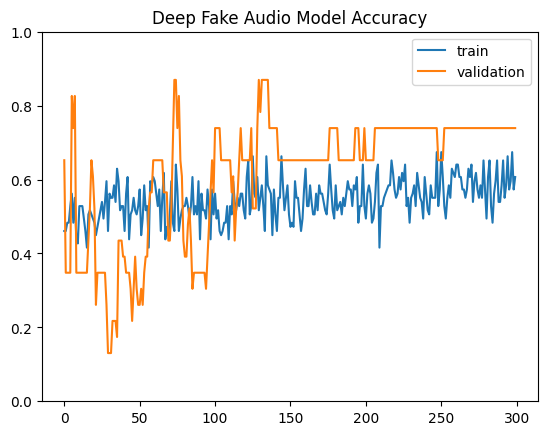

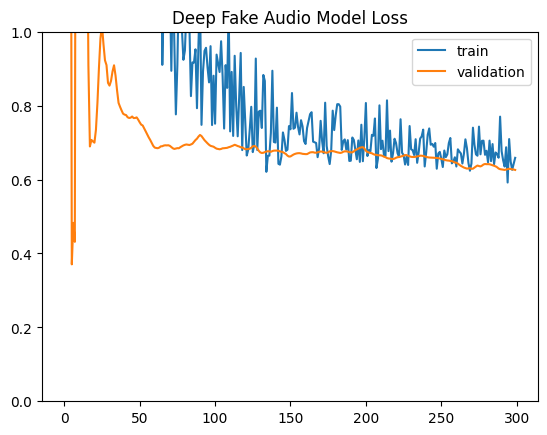

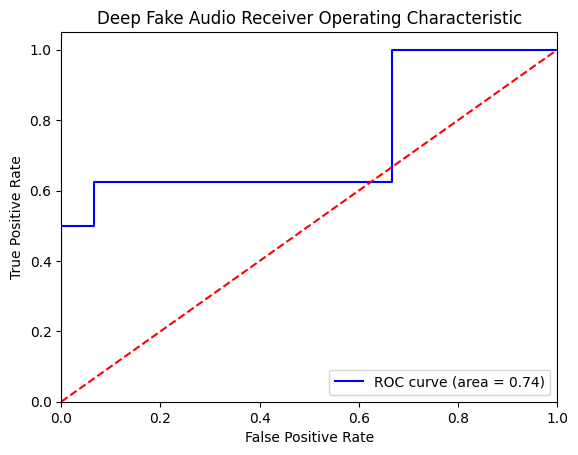

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, confusion_matrix, roc_curve, auc)

# Make predictions on the test set
audio_predictions = audio_model.predict(audio_X_test)

# Convert predictions to binary
audio_predictions_binary = (audio_predictions > 0.5).astype(int)

# Calculate metrics
audio_accuracy = accuracy_score(np.argmax(audio_y_test, axis=1), np.argmax(audio_predictions_binary, axis=1))
audio_f1 = f1_score(np.argmax(audio_y_test, axis=1), np.argmax(audio_predictions_binary, axis=1), average='weighted')
audio_precision = precision_score(np.argmax(audio_y_test, axis=1), np.argmax(audio_predictions_binary, axis=1), average='weighted')
audio_recall = recall_score(np.argmax(audio_y_test, axis=1), np.argmax(audio_predictions_binary, axis=1), average='weighted')
audio_cm = confusion_matrix(np.argmax(audio_y_test, axis=1), np.argmax(audio_predictions_binary, axis=1))

# AUC and ROC
audio_fpr, audio_tpr, audio_thresholds = roc_curve(np.argmax(audio_y_test, axis=1), audio_predictions[:, 1])  # Assuming the second column is for the positive class
audio_roc_auc = auc(audio_fpr, audio_tpr)

# Print metrics
print(f"Deep Fake Audio Accuracy: {audio_accuracy}")
print(f"Deep Fake Audio F1 Score: {audio_f1}")
print(f"Deep Fake Audio Precision: {audio_precision}")
print(f"Deep Fake Audio Recall: {audio_recall}")
print("Deep Fake Audio Confusion Matrix:\n", audio_cm)
print(f"Deep Fake Audio AUC: {audio_roc_auc}")

# Plot training & validation accuracy values
plt.figure()
plt.title("Deep Fake Audio Model Accuracy")
plt.plot(audio_history.history["accuracy"], label="train")
plt.plot(audio_history.history["val_accuracy"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

# Plot training & validation loss values
plt.figure()
plt.title("Deep Fake Audio Model Loss")
plt.plot(audio_history.history["loss"], label="train")
plt.plot(audio_history.history["val_loss"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

# Plot ROC Curve
plt.figure()
plt.plot(audio_fpr, audio_tpr, color='blue', label='ROC curve (area = %0.2f)' % audio_roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Deep Fake Audio Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# Multimodal Model with Advanced Improvements
Key Benefits
1. Attention Mechanisms: Dynamically weigh the importance of visual and audio features.

2. Cross-Modal Fusion: Combine features at an intermediate layer for better joint representation.

3. Post-Processing: Refine decoded text using GPT-2 for better readability.

In [2]:
!pip install tensorflow moviepy librosa opencv-python numpy transformers gdown

  Using cached moviepy-2.1.2-py3-none-any.whl.metadata (6.9 kB)
  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached imageio_ffmpeg-0.6.0-py3-none-win_amd64.whl.metadata (1.5 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached soundfile-0.13.1-py2.py3-none-win_amd64.whl.metadata (16 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached soxr-0.5.0.post1-cp312-abi3-win_amd64.whl.metadata (5.6 kB)
  Using cached tokenizers-0.21.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl.metadata (3.9 kB)
Using cached moviepy-2.1.2-py3-none-any.whl (126 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)
   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   ----------------------

In [34]:
!pip install tf-keras
import tf_keras
print(tf_keras.__version__)

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------ --------------------------- 0.5/1.7 MB 2.4 MB/s eta 0:00:01
   ------------------ --------------------- 0.8/1.7 MB 2.2 MB/s eta 0:00:01
   ------------------ --------------------- 0.8/1.7 MB 2.2 MB/s eta 0:00:01
   ------------------ --------------------- 0.8/1.7 MB 2.2 MB/s eta 0:00:01
   ------------------------ --------------- 1.0/1.7 MB 867.1 kB/s eta 0:00:01
   ------------------------ --------------- 1.0/1.7 MB 867.1 kB/s eta 0:00:01
   ------------------------------ --------- 1.3/1.7 MB 828.3 kB/s eta 0:00:01
   ------------------------------ --------- 1.3/1.7 MB 828.3 kB/s eta 0:00:01
   ------------------------------------ --- 1.6/1.7 MB 755.5 kB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 749.6 kB/s eta 0:00:00



2.19.0


In [ ]:
# Multimodal System
import tensorflow as tf
from tensorflow.keras.layers import Input, MultiHeadAttention, Add, Dense, TimeDistributed, GlobalAveragePooling1D, Layer
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import gdown
import os
import numpy as np
import cv2
import moviepy as mp
import librosa
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel


In [25]:
# Define CTC Loss with Dynamic Label Lengths
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")  # 75 timesteps
    label_length = tf.reduce_sum(tf.cast(y_true != -1, tf.int64), axis=1)  # Count non-padding (-1) elements
    
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length[:, tf.newaxis]  # Reshape to (batch_size, 1)
    
    return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

In [26]:
# Vocabulary
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
num_to_char = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="", invert=True)
vocab_size = len(vocab) + 1  # 40 (36 chars + space + blank + extras)

# Load Lip Model
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

lip_model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2)),
    tf.keras.layers.Conv3D(256, 3, padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2)),
    tf.keras.layers.Conv3D(75, 3, padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
])

checkpoint_dir = 'models'
checkpoint_file = tf.train.latest_checkpoint(checkpoint_dir)
if checkpoint_file:
    checkpoint = tf.train.Checkpoint(model=lip_model)
    checkpoint.restore(checkpoint_file).expect_partial()
    print(f"Lip model weights loaded from: {checkpoint_file}")
else:
    raise ValueError("No valid checkpoint found in 'models' directory.")

# Load Audio Model
audio_model_path = 'C:/Users/omkar/LipNet/audio_classification_model.h5'  # Update path
audio_model = load_model(audio_model_path)
print(f"Audio model loaded from: {audio_model_path}")

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=8fdbfa6e-0c70-4521-8c42-9770861b9d1b
To: C:\Users\omkar\LipNet\checkpoints.zip
100%|██████████████████████████████████████████████████████████████████████████████████████████| 94.5M/94.5M [00:28<00:00, 3.31MB/s]


Lip model weights loaded from: models\checkpoint


Audio model loaded from: C:/Users/omkar/LipNet/audio_classification_model.h5


In [27]:
# Custom Audio Tiling Layer
class AudioTilingLayer(Layer):
    def __init__(self, **kwargs):
        super(AudioTilingLayer, self).__init__(**kwargs)

    def call(self, inputs):
        lip_features, audio_features = inputs
        T = tf.shape(lip_features)[1]
        audio_expanded = tf.expand_dims(audio_features, axis=1)
        audio_tiled = tf.tile(audio_expanded, [1, T, 1])
        return audio_tiled

# Create Multimodal Model
lip_model.trainable = False
audio_model.trainable = False

lip_input = Input(shape=(75, 46, 140, 1), name='lip_input')
audio_input = Input(shape=(40,), name='audio_input')

lip_features = lip_model(lip_input)
audio_features = audio_model(audio_input)

audio_tiled = AudioTilingLayer()([lip_features, audio_features])
attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(lip_features, audio_tiled)
fused_features = Add()([lip_features, attention_output])

ctc_output = TimeDistributed(Dense(vocab_size, activation='softmax'), name='ctc_output')(fused_features)
pooled = GlobalAveragePooling1D()(fused_features)
classification_output = Dense(1, activation='sigmoid', name='classification_output')(pooled)

multimodal_model = Model(inputs=[lip_input, audio_input], outputs=[ctc_output, classification_output])

multimodal_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={'ctc_output': CTCLoss, 'classification_output': 'binary_crossentropy'},
    metrics={'classification_output': 'accuracy'}
)

multimodal_model.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ lip_input (InputLayer)        │ (None, 75, 46, 140, 1)    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ audio_input (InputLayer)      │ (None, 40)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_2 (Sequential)     │ (None, 75, 40)            │       8,471,667 │ lip_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_6 (Sequential)     │ (None, 2)                 │          71,426 │ audio_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ audio_tiling_layer_3          │ (None, 75, 2)             │               0 │ sequential_2[0][0],        │
│ (AudioTilingLayer)            │                           │                 │ sequential_6[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_3        │ (None, 75, 40)            │          22,312 │ sequential_2[0][0],        │
│ (MultiHeadAttention)          │                           │                 │ audio_tiling_layer_3[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_3 (Add)                   │ (None, 75, 40)            │               0 │ sequential_2[0][0],        │
│                               │                           │                 │ multi_head_attention_3[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d_3    │ (None, 40)                │               0 │ add_3[0][0]                │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ctc_output (TimeDistributed)  │ (None, 75, 40)            │           1,640 │ add_3[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classification_output (Dense) │ (None, 1)                 │              41 │ global_average_pooling1d_… │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 8,567,086 (32.68 MB)

 Trainable params: 23,993 (93.72 KB)

 Non-trainable params: 8,543,093 (32.59 MB)

In [28]:
# Generate Proper Dummy Data
batch_size_train = 100
batch_size_test = 20
max_label_length = 20

# Input data
lip_X_train = np.random.rand(batch_size_train, 75, 46, 140, 1).astype(np.float32)
audio_X_train = np.random.rand(batch_size_train, 40).astype(np.float32)
lip_X_test = np.random.rand(batch_size_test, 75, 46, 140, 1).astype(np.float32)
audio_X_test = np.random.rand(batch_size_test, 40).astype(np.float32)

# CTC labels with -1 as padding
y_train_ctc = np.full((batch_size_train, 75), -1, dtype=np.int32)  # -1 for padding
y_test_ctc = np.full((batch_size_test, 75), -1, dtype=np.int32)
for i in range(batch_size_train):
    length = np.random.randint(5, max_label_length + 1)
    y_train_ctc[i, :length] = np.random.randint(0, vocab_size - 1, length)  # 0–38
for i in range(batch_size_test):
    length = np.random.randint(5, max_label_length + 1)
    y_test_ctc[i, :length] = np.random.randint(0, vocab_size - 1, length)

# Classification labels
y_train_class = np.random.randint(0, 2, (batch_size_train, 1)).astype(np.float32)
y_test_class = np.random.randint(0, 2, (batch_size_test, 1)).astype(np.float32)

In [29]:
# Train the Model
early = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
history = multimodal_model.fit(
    [lip_X_train, audio_X_train],
    {'ctc_output': y_train_ctc, 'classification_output': y_train_class},
    validation_data=([lip_X_test, audio_X_test], {'ctc_output': y_test_ctc, 'classification_output': y_test_class}),
    batch_size=16,
    epochs=100,
    callbacks=[early]
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 173s 21s/step - classification_output_accuracy: 0.4181 - classification_output_loss: 0.7016 - ctc_output_loss: 228.4343 - loss: 229.3027 - val_classification_output_accuracy: 0.6000 - val_classification_output_loss: 0.6720 - val_ctc_output_loss: 222.0878 - val_loss: 222.6457
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 158s 23s/step - classification_output_accuracy: 0.4572 - classification_output_loss: 0.6972 - ctc_output_loss: 224.6167 - loss: 225.3554 - val_classification_output_accuracy: 0.6000 - val_classification_output_loss: 0.6725 - val_ctc_output_loss: 218.5675 - val_loss: 219.1283
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 158s 23s/step - classification_output_accuracy: 0.4574 - classification_output_loss: 0.6976 - ctc_output_loss: 220.4982 - loss: 221.3178 - val_classification_output_accuracy: 0.6000 - val_classification_output_loss: 0.6731 - val_ctc_output_loss: 214.6056 - val_loss: 215.1731
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 146s 21s/step - classifi

In [52]:
# Inference Functions
def extract_frames(video_path):
    print(f"Opening video: {video_path}")
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file not found: {video_path}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {video_path}")
    
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (140, 46))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(frame)
    cap.release()
    
    print(f"Number of frames extracted: {len(frames)}")
    if len(frames) == 0:
        raise ValueError("No frames extracted from video. Check file path or video content.")
    
    frames = np.array(frames)
    print(f"Frames shape before padding: {frames.shape}")
    
    if len(frames) < 75:
        frames = np.pad(frames, ((0, 75 - len(frames)), (0, 0), (0, 0)), mode='constant')
    else:
        frames = frames[:75]
    
    print(f"Frames shape after padding/cropping: {frames.shape}")
    frames = frames / 255.0
    frames = np.expand_dims(frames, axis=-1)
    print(f"Final frames shape: {frames.shape}")
    return frames

def extract_audio(video_path):
    print(f"Extracting audio from: {video_path}")
    video = mp.VideoFileClip(video_path)
    audio_path = video_path.replace('.mp4', '.wav')
    video.audio.write_audiofile(audio_path)
    audio, sample_rate = librosa.load(audio_path, sr=16000)
    print(f"Audio extracted, sample rate: {sample_rate}")
    return audio, sample_rate

def extract_audio_features(audio, sample_rate):
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfcc = np.mean(mfcc.T, axis=0)
    print(f"Audio features shape: {mfcc.shape}")
    return mfcc

# Optimize GPT-2 loading with TensorFlow
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = TFGPT2LMHeadModel.from_pretrained('gpt2')

def refine_text_with_gpt(text):
    if not text:
        return "No text predicted"
    inputs = tokenizer.encode(text, return_tensors='tf')
    outputs = gpt2_model.generate(inputs, max_length=50, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)
    refined_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return refined_text

def load_data(video_path):
    # Extract frames
    frames = extract_frames(video_path)
    # Load label from .align file if it exists, otherwise use placeholder
    align_path = video_path.replace('.mp4', '.align')  # Adjusted for .mp4
    if os.path.exists(align_path):
        with open(align_path, 'r') as f:
            lines = f.readlines()
            words = [line.split()[2] for line in lines if line.strip()]
            label = tf.convert_to_tensor([vocab.index(c) if c in vocab else -1 for c in ' '.join(words)], dtype=tf.int64)
    else:
        print(f"Warning: No .align file found at {align_path}. Using placeholder label.")
        label = tf.convert_to_tensor([vocab.index(c) if c in vocab else -1 for c in "hello world"], dtype=tf.int64)
    return frames, label

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [58]:
# Test Inference
test_video_path = 'C:/Users/omkar/LipNet/test_video.mp4'
lip_sample, real_label = load_data(test_video_path)

# Print real text
print('~'*100, 'REAL TEXT')
print([tf.strings.reduce_join([num_to_char(word) for word in real_label]).numpy().decode('utf-8')])

# Preprocess inputs
test_frames = np.expand_dims(lip_sample, axis=0)  # (1, 75, 46, 140, 1)
test_audio, test_sample_rate = extract_audio(test_video_path)
test_audio_features = extract_audio_features(test_audio, test_sample_rate)
test_audio_features = np.expand_dims(test_audio_features, axis=0)  # (1, 40)

# Make predictions
ctc_output, classification_output = multimodal_model.predict([test_frames, test_audio_features])

# Interpret CTC output
predicted = tf.keras.backend.ctc_decode(ctc_output, input_length=[75], greedy=True)[0][0].numpy()
print('~'*100, 'PREDICTED TEXT')
print([tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8') for sentence in [predicted]])

# Interpret classification output
classification = "Fake" if classification_output[0][0] >= 0.5 else "Real"
print("Classification:", classification)

Opening video: C:/Users/omkar/LipNet/test_video.mp4
Number of frames extracted: 75
Frames shape before padding: (75, 46, 140)
Frames shape after padding/cropping: (75, 46, 140)
Final frames shape: (75, 46, 140, 1)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
['gdkkn9vnqkc']
Extracting audio from: C:/Users/omkar/LipNet/test_video.mp4
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf59.4.101'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [360, 288], 'bitrate': 159, 'fps': 25.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrat

MoviePy - Done.
Audio extracted, sample rate: 16000
Audio features shape: (40,)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTED TEXT
['']
Classification: Real


In [64]:
# Save Model
multimodal_model.save('C:/Users/omkar/LipNet/multimodal_model.keras')
print("Full model saved to 'multimodal_model.keras'")

Full model saved to 'multimodal_model.keras'
